In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

In [3]:
colab_flag = True

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

Mounted at /content/drive


In [6]:
print(os.getcwd())

/content/drive/MyDrive/Github/MLROM/KS


In [7]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if gpus:
        gpu_to_use = 0
        tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
        logical_devices = tf.config.list_logical_devices('GPU')
        print(logical_devices)

[]


In [8]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS, readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v3 import Autoencoder
from tools.GRU_CHS_AR_v1 import AR_RNN_GRU_CHS
from tools.GRU_CHS_TF_v1 import TF_RNN_GRU_CHS

In [9]:
print(tf.test.gpu_device_name())
print(tf.__version__)


2.9.2


# KS System

In [10]:
# setting up params (and saving, if applicable)
from numpy import *

# RNN directory
dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_003'

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

# reading RNN paramaters
with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
    lines = f.readlines()

params_rnn_dict = eval(''.join(lines))

dt_rnn = params_rnn_dict['dt_rnn']
T_sample_input = params_rnn_dict['T_sample_input']
T_sample_output = params_rnn_dict['T_sample_output']
T_offset = params_rnn_dict['T_offset']
return_params_arr = params_rnn_dict['return_params_arr']
params = params_rnn_dict['params']
try:
    normalize_dataset = params_rnn_dict['normalize_dataset']
except:
    print("'normalize_dataset' not present in RNN_specific_data, set to False.")
    normalize_dataset = False

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']

print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

fl = np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True)
all_data = fl['all_data']
boundary_idx_arr = fl['boundary_idx_arr']
normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
initial_t0 = fl['initial_t0']

# training params
with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
    lines = f.readlines()

tparams_dict = eval(''.join(lines))

learning_rate_dict = tparams_dict['learning_rate_dict']
epochs = tparams_dict['epochs']
patience = tparams_dict['patience']
min_delta = tparams_dict['min_delta']
prng_seed = tparams_dict['prng_seed']
train_split = tparams_dict['train_split']
val_split = tparams_dict['val_split']
batch_size = tparams_dict['batch_size']

test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_rnn: /content/drive/MyDrive/Github/MLROM/KS/saved_rnn/rnn_003
dir_name_ae: /content/drive/MyDrive/Github/MLROM/KS/saved_ae/ae_007
data_dir_idx: 001
normalize_flag_ogdata: False


In [11]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

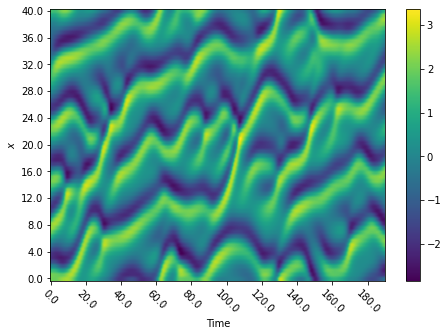

In [12]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid)

In [13]:
# delaing with normalizing the data before feeding into autoencoder
if normalizeforae_flag == True:
    for i in range(numpoints_xgrid):
        all_data[:, i] -= normalization_constant_arr_aedata[0, i]
        all_data[:, i] /= normalization_constant_arr_aedata[1, i]

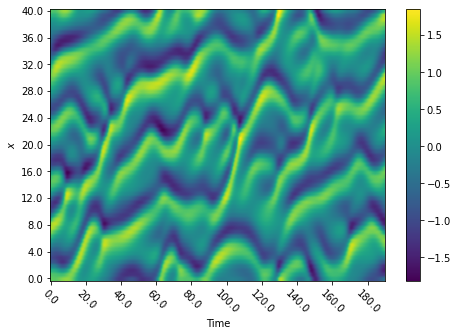

In [14]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid)

# Autoencoder

In [15]:
from tools.ae_v3 import Autoencoder

In [16]:
# load_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_class_dict.txt'
# wt_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_ae_weights.h5'

load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [17]:
ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
ae_net.load_weights_from_file(wt_file)

In [18]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)
num_latent_states = latent_states_all.shape[1]

60/60 [==============================] - 0s 1ms/step


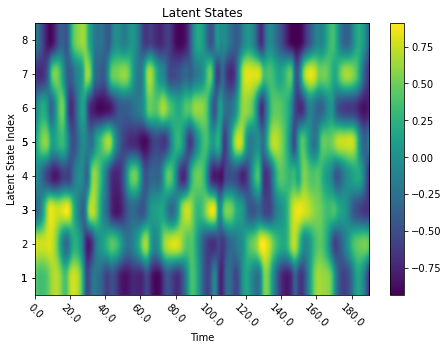

In [19]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=20,
    num_yticks=11,
    save_figs=False)

In [20]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# AR-GRU-CHS

In [71]:
T_sample_input_AR = 50.1*dt_rnn
T_sample_output_AR = 13*10
T_offset_AR = T_sample_input_AR

T_sample_input_AR = T_sample_input_AR + T_sample_output_AR

In [72]:
AR_rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input_AR,
    T_sample_output_AR,
    T_offset_AR,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset)
    
data_rnn_input = AR_rnn_res_dict['data_rnn_input']
data_rnn_output = AR_rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = AR_rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = AR_rnn_res_dict['org_data_idx_arr_output']
num_samples = AR_rnn_res_dict['num_samples']
normalization_arr = AR_rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = AR_rnn_res_dict['rnn_data_boundary_idx_arr']

if normalize_dataset == True:
    with open(dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'rnn_normalization.txt') as f:
        lines = f.readlines()

    norm_dict = eval(''.join(lines))
    normalization_arr = norm_dict['normalization_arr']
    
    for i in range(latent_states_all.shape[1]):
        data_rnn_input[:, :, i] -= normalization_arr[0, i]
        data_rnn_input[:, :, i] /= normalization_arr[1, i]
        # data_rnn_output[:, :, i] -= normalization_arr[0, i]
        # data_rnn_output[:, :, i] /= normalization_arr[1, i]
else:
    normalization_arr=None

In [73]:
# Initialize networks
load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'

# this loads just the kernel wieghts and biases of the model
wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_gru_weights.h5'

# autoregressive network
rnn_net_AR = AR_RNN_GRU_CHS(
    load_file=load_file,
    T_input=T_sample_input_AR,
    T_output=T_sample_output_AR,
)
rnn_net_AR.load_weights_from_file(wt_file)

# teacher forced network
rnn_net_TF = TF_RNN_GRU_CHS(
    load_file=load_file,
    T_input=T_sample_input_AR,
    T_output=T_sample_output_AR,
)
rnn_net_TF.load_weights_from_file(wt_file)

1/1 [==============================] - 66s 66s/step


In [74]:
with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
    lines = f.readlines()

losses_dict = eval(''.join(lines))

val_loss_hist = losses_dict['val_loss_hist']
train_loss_hist = losses_dict['train_loss_hist']
lr_change = losses_dict['lr_change']
test_loss = losses_dict['test_loss']

In [75]:
# compiling the networks
rnn_net_AR.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_dict['eta_begin']),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

rnn_net_TF.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_dict['eta_begin']),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

In [76]:
# %pdb

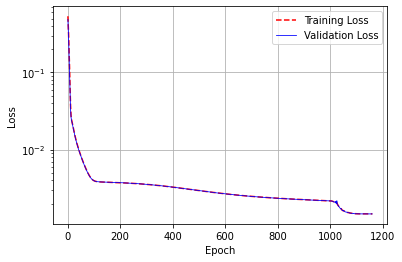

In [77]:
# plotting losses

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=None
)

# plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()

In [78]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    for i in range(data.shape[-1]):
        new_data[:, i] -= normalization_arr[0, i]
        new_data[:, i] /= normalization_arr[1, i]

    return new_data

def norm_sq_time_average(data):
    data_norm_sq = np.zeros(shape=data.shape[0])
    for i in range(data.shape[1]):
        data_norm_sq[:] += data[:, i]**2
    # integrating using the trapezoidal rule
    norm_sq_time_avg = np.sum(data_norm_sq) - 0.5*(data_norm_sq[0]+data_norm_sq[-1])
    norm_sq_time_avg /= data_norm_sq.shape[0]
    return norm_sq_time_avg

def invert_normalization(data, normalization_arr):
    new_data = data.copy()
    shape = new_data.shape
    for i in range(shape[-1]):
        if len(shape) == 2:
            new_data[:, i] *= normalization_arr[1, i]
            new_data[:, i] += normalization_arr[0, i]
        elif len(shape) == 3:
            new_data[:, :, i] *= normalization_arr[1, i]
            new_data[:, :, i] += normalization_arr[0, i]
    return new_data

data_idx : 98
1/1 [==============================] - 29s 29s/step


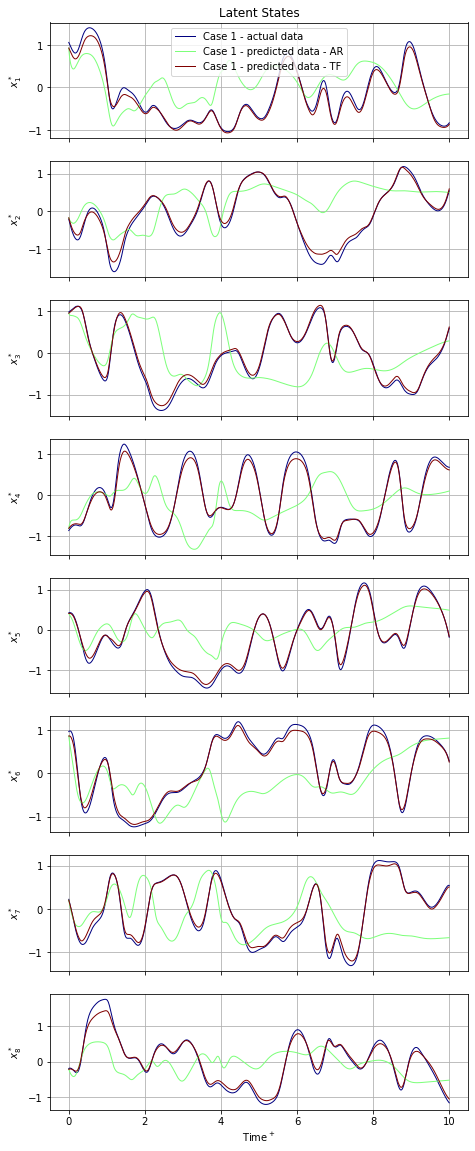


prediction_horizon_AR: 0.08470000000000001
prediction_horizon_TF: 10.0023


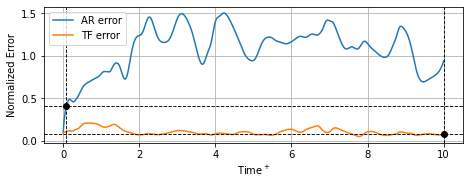

In [79]:
lyap_exp = 0.077
error_threshold = 0.4

#--- SELECTING INPUT DATA AND MAKING PREDICTIONS ---#
data_in = data_rnn_input
data_out = data_rnn_output

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 11269
print('data_idx : {}'.format(data_idx))

data_out = data_out[data_idx]
# data_out = rescale_data(data_out, normalization_arr)

predictions_AR, hidden_states_AR = rnn_net_AR.predict(data_in[data_idx:data_idx+1, :, :])
predictions_TF, hidden_states_TF = rnn_net_TF.predict(data_in[data_idx:data_idx+1, :, :])

predictions_AR = invert_normalization(predictions_AR, normalization_arr)
predictions_TF = invert_normalization(predictions_TF, normalization_arr)
#--- PREDICTIONS END ---#



#--- PLOTTING BEGINS ---#
n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = ['$x^*_{}$'.format(i) for i in range(1, num_latent_states+1)]
fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn*lyap_exp

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 3*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out_AR = ax[j].plot(input_time, predictions_AR[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data - AR'.format(i+1))
        obj_out_TF = ax[j].plot(input_time, predictions_TF[0, :, j], linewidth=1, color=colors[2*i+2], label='Case {} - predicted data - TF'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out_AR[0])
        mpl_ax_artist_list.append(obj_out_TF[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)

ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)
plt.show()
# plt.savefig('AR-GRU.png', dpi=300, bbox_inches='tight')
print('')

# Error and prediction horizon
timemean_of_spacenorm = norm_sq_time_average(data_out)**0.5
error_AR = np.linalg.norm(data_out[:, :] - predictions_AR[0, :, :], axis=1)
error_AR /= timemean_of_spacenorm
error_TF = np.linalg.norm(data_out[:, :] - predictions_TF[0, :, :], axis=1)
error_TF /= timemean_of_spacenorm

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error_AR, label='AR error')
ax2.plot(input_time, error_TF, label='TF error')
ax2.legend(loc='best')
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

predhor_idx_AR = np.where(error_AR >= error_threshold)[0]
predhor_idx_TF = np.where(error_TF >= error_threshold)[0]
if len(predhor_idx_AR) == 0:
    predhor_idx_AR = len(error_AR)-1
else:
    predhor_idx_AR = predhor_idx_AR[0]
if len(predhor_idx_TF) == 0:
    predhor_idx_TF = len(error_TF)-1
else:
    predhor_idx_TF = predhor_idx_TF[0]

ax2.plot(input_time[predhor_idx_AR], error_AR[predhor_idx_AR], 'o', color='k')
ax2.axhline(error_AR[predhor_idx_AR], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx_AR], linewidth=0.9, linestyle='--', color='k')

ax2.plot(input_time[predhor_idx_TF], error_TF[predhor_idx_TF], 'o', color='k')
ax2.axhline(error_TF[predhor_idx_TF], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx_TF], linewidth=0.9, linestyle='--', color='k')

prediction_horizon_AR = predhor_idx_AR*dt_rnn*lyap_exp
prediction_horizon_TF = predhor_idx_TF*dt_rnn*lyap_exp

print('prediction_horizon_AR:', prediction_horizon_AR)
print('prediction_horizon_TF:', prediction_horizon_TF)

plt.show()
#--- PLOTTING ENDS ---#

In [80]:
data_in.shape

(551, 1350, 8)

In [81]:
data_in_og = data_rnn_input
data_out_og = data_rnn_output

print('data_in.shape[0]:', data_in.shape[0])

num_runs = 30
# error_threshold = 0.4

# data_idx_arr = np.arange(data_in_og.shape[0])
# np.random.shuffle(data_idx_arr)
data_idx_arr = np.linspace(0, data_in.shape[0]-1, num_runs, dtype=np.int32)

predictions_AR, hidden_states_AR = rnn_net_AR.predict(data_in_og[data_idx_arr[0:num_runs], :, :])
predictions_TF, hidden_states_TF = rnn_net_TF.predict(data_in_og[data_idx_arr[0:num_runs], :, :])

predictions_AR = invert_normalization(predictions_AR, normalization_arr)
predictions_TF = invert_normalization(predictions_TF, normalization_arr)

data_in.shape[0]: 551
1/1 [==============================] - 0s 290ms/step


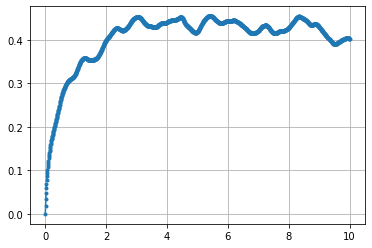

In [82]:
# mean in numberofbatches axis
hs_diff = hidden_states_AR[0] - hidden_states_TF[0]
for i in range(1, hidden_states_AR.shape[0]):
    hs_diff += hidden_states_AR[i] - hidden_states_TF[i]
hs_diff /= hidden_states_AR.shape[0]

# RMS in last dimension
hs_diff = np.linalg.norm(hs_diff, axis=-1) / (hs_diff.shape[-1]**0.5)

# mean in batchsize axis
hs_diff = np.mean(hs_diff, axis=1)

plt.plot(input_time, hs_diff, marker='o', linestyle='--', markersize=3)
plt.grid(True)
plt.show()

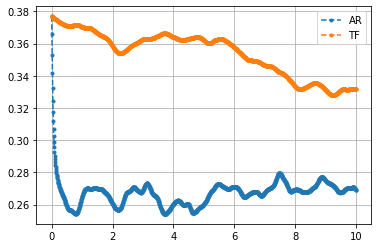

In [83]:
# mean in numberofbatches axis
hs_AR = hidden_states_AR[0]
for i in range(1, hidden_states_AR.shape[0]):
    hs_AR += hidden_states_AR[i]
hs_AR /= hidden_states_AR.shape[0]

hs_TF = hidden_states_TF[0]
for i in range(1, hidden_states_TF.shape[0]):
    hs_TF += hidden_states_TF[i]
hs_TF /= hidden_states_TF.shape[0]

# RMS in last dimension
hs_AR = np.linalg.norm(hs_AR, axis=-1) / (hs_AR.shape[-1]**0.5)
hs_TF = np.linalg.norm(hs_TF, axis=-1) / (hs_TF.shape[-1]**0.5)

# mean in batchsize axis
hs_AR = np.mean(hs_AR, axis=1)
hs_TF = np.mean(hs_TF, axis=1)

plt.plot(input_time, hs_AR, marker='o', linestyle='--', markersize=3)
plt.plot(input_time, hs_TF, marker='o', linestyle='--', markersize=3)
plt.legend(['AR', 'TF'])
plt.grid(True)
plt.show()